In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format, apply_date_to_week
from utils.plotting import *
from src.src import *

In [4]:
# Load data
model_type = "ols"
data_len = 8055 # 440, 660, 760, 1560, 8055
is_sent = False
week_day = 'daily'

df_w = load_data(file_name=f"df_{week_day}_{data_len}.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name=f"dict_{week_day}_{data_len}.pkl", file_path=WORK_DATA_DIR)

In [5]:
# update dict with model specific information
data_dict["model_features"].update(datetime_ind=dict(zip(df_w.index, df_w.date)))

data_dict["model_metrics"].update(model_type=model_type)
data_dict["model_metrics"].update(data_len=data_len)
data_dict["model_metrics"].update(is_sent=is_sent)
data_dict["model_metrics"].update(week_day=week_day)
data_dict["model_metrics"].update(model_name=f"{model_type}_{data_len}_{data_dict['model_metrics']['year_spread']}_{data_dict['model_features']['predicted']}_sent{is_sent}")

# data selection

In [6]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
    # 'vixo',
    # 'vixo_lag1',
    #  'vixo_lag2',
    #  'vixo_lag3',
    #  'vixo_lag4',
    #  'vixo_lag5',
    #  'vixo_lag6',
    #  'vixo_lag7',
    #  'vixo_lag8',
    #  'vixo_lag9',
    #  'vixo_lag10',
    #  'vixo_lag11',
    #  'vixo_lag12',
    #  'vixo_lag13',
    #  'vixo_lag14',
    #  'vixo_lag15',
    #  'vixo_lag16',
    #  'vixo_lag17',
    #  'vixo_lag18',
    #  'vixo_lag19',
    #  'vixo_lag20',
     # 'naaim_ind',
     # 'naaim_max',
     # 'naaim_q1',
     'ff_M_RF',
     # 'ff_M_RF_lag1',
     # 'ff_M_RF_lag2',
     # 'ff_M_RF_lag3',
     # 'ff_M_RF_lag4',
     # 'ff_M_RF_lag5',
     # 'ff_M_RF_lag6',
     # 'ff_M_RF_lag7',
     # 'ff_M_RF_lag8',
     # 'ff_M_RF_lag9',
     'ff_SMB',
     'ff_HML',
     'ff_RMW',
     'ff_CMA',
     # 'termspread',
     # 'pc_ratio',
     # 'fears35',
     # 'aaii_Bullish',
     # 'aaii_Bearish',
     # 'aaii_Neutral',
     'sp_close',
     'sp_close_lag1',
     'sp_close_lag2',
     # 'sp_close_lag3',
     'sp_close_lag4',
     # 'sp_close_lag5',
     'sp_close_lag6',
     'sp_close_lag7',
     'sp_close_lag8',
     'sp_close_lag9',
     # 'sp_close_lag10',
     # 'sp_close_lag11',
     # 'sp_close_lag12',
     'sp_close_lag13',
     # 'sp_close_lag14',
     # 'sp_close_lag15'
]

categorical = [    
     # 'weekday',
     # 'weekday_0',
     # 'weekday_1',
     # 'weekday_2',
     # 'weekday_3',
     # 'weekday_4'
]

## categorical features
if len(categorical) > 0:
    cols = cols + categorical
    data_dict["model_features"]["categorical"] = categorical

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

# TTS

In [7]:
df_ws = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

In [8]:
df_train = df_ws.copy()

In [9]:
X_train, X_test, y_train, y_test = tts_data(df_train,
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            random_split=False,
                                            test_size=.3,
                                            add_const=False)

# Sesonality


 Len of complete weeks in X_train: 225


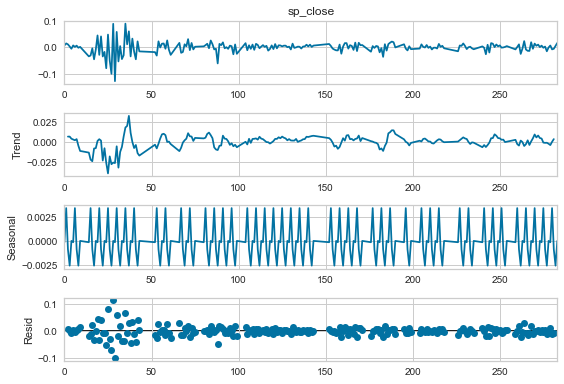

In [10]:
# create sub dataframe of X_train
X_train_sea = X_train.copy()

# insert datetime information
X_train_sea["date"] = pd.Series(X_train_sea.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x]).values
X_train_sea["weekday"] = is_day(X_train_sea.date)
X_train_sea["week"] = X_train_sea.date.apply(lambda x: apply_date_to_week(x))

# create seasonality object
sd = SeasonalTrend(X_train_sea, 'sp_close', 'week', 'weekday', 5, show_fig=True)       
sd.split_time_series()

 # map sesonality to data
if week_day == 'daily': 
    data_dict["model_features"]["weekday_seasonality"] = sd.dict_map_sasonal
    
    _ = pd.Series(X_test.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x])
    X_test["seasonal"] = is_day(_).map(data_dict["model_features"]["weekday_seasonality"]).values

    _ = pd.Series(X_train.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x])
    X_train["seasonal"] = is_day(_).map(data_dict["model_features"]["weekday_seasonality"]).values

    cols.append("seasonal")

# Corr

In [11]:
# merging X, y for analysis purposes
X_train = pd.concat([X_train, y_train], axis=1)

Corr matrix

In [12]:
## ORTHOGONALISE
X_train = orthogonalise_vars(X_train, X="sp_close", y="ff_M_RF", show_fig=False)
# X_train = orthogonalise_vars(X_train, X="sp_close_lag1", y="ff_M_RF_lag1", show_fig=False)

,VIF,corr_sp_close_lead1
sp_close,1.470192,-0.333861
sp_close_lag7,1.450725,-0.263966
sp_close_lag9,1.364364,-0.095971
sp_close_lag2,1.396263,-0.036065
ff_HML,2.854282,-0.035792
seasonal,1.031782,-0.000030
ff_RMW,1.854871,0.008333
ff_CMA,1.542560,0.034084
ff_SMB,2.423881,0.067317
ff_M_RF,1.609841,0.105485


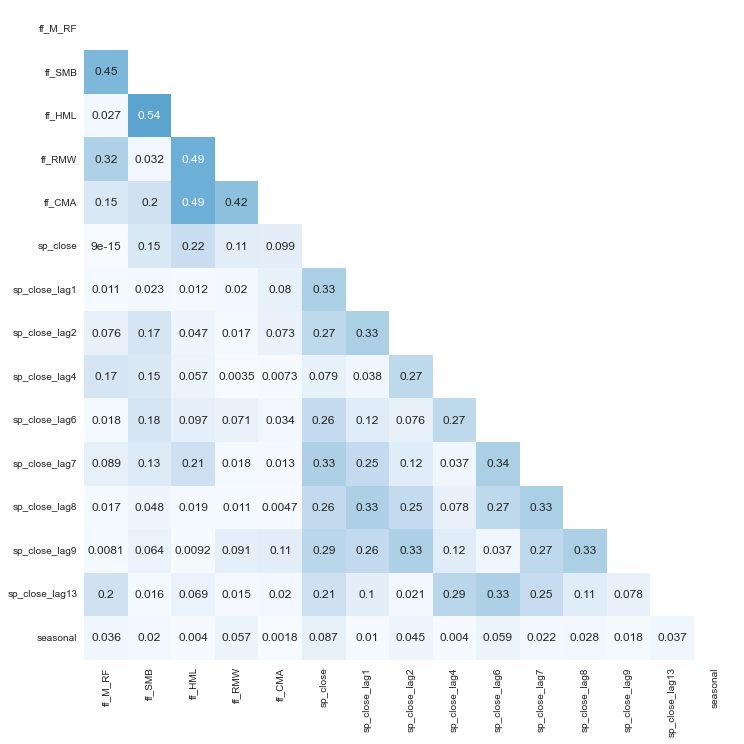

In [13]:
# only rely on correlation not vif
corr_heatmap(X_train, 
             cols,
             size_factor=.7,
             show_fig=True)

get_variance_inflation_factor(
                              X_train,
                              # pd.concat([X_test, y_test], axis=1),
                              cols,
                              col_pred=data_dict["model_features"]["predicted"])

# Model

In [14]:
# dropping y col from X_train
X_train.drop(data_dict["model_features"]['predicted'], axis=1, inplace=True)
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

In [15]:
model_wrap = ExpandingPredictionOLS(SKLearnWrap(sm.OLS),
                    X_train,
                    y_train,
                    X_test,
                    y_test)

# Out of sample eval

In [16]:
# benchmark: mittelwert prognose - das ist ein random walk mit drift

In [17]:
mval = ModelValidation(
            X_train=X_train,
            y_train=y_train,
            X_validate=X_test,
            y_validate=y_test,
            model=model_wrap,
            print_results=True)

In [18]:
mval.model.model.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sp_close_lead1   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     8.223
Date:                Fri, 01 Apr 2022   Prob (F-statistic):           2.50e-16
Time:                        17:29:29   Log-Likelihood:                 1122.3
No. Observations:                 409   AIC:                            -2213.
Df Residuals:                     393   BIC:                            -2148.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
ff_M_RF            0.2238      0.201      1.115      0.265      -0.171       0.618
ff_SMB             0.3007      0.110      2.731      0.007       0.084       0.517
ff_HML            -0.0900      0.089     -1.011      0.313      -0.265       0.085
ff_RMW             0.2600      0.163      1.597      0.111      -0.060       0.580
ff_CMA            -0.1468      0.194     -0.756      0.450      -0.528       0.235
sp_close          -0.2279      0.054     -4.216      0.000      -0.334      -0.122
sp_close_lag1      0.1448      0.050      2.896      0.004       0.046       0.243
sp_close_lag2      0.0803      0.051      1.579      0.115      -0.020       0.180
sp_close_lag4      0.0057      0.050      0.114      0.909      -0.093       0.104
sp_close_lag6      0.2209      0.052      4.274      0.000       0.119       0.323
sp_close_lag7     -0.0645      0.052     -1.253      0.211      -0.166       0.037
sp_close_lag8      0.1317      0.051      2.585      0.010       0.032       0.232
sp_close_lag9      0.0271      0.051      0.536      0.592      -0.072       0.126
sp_close_lag13    -0.0193      0.049     -0.394      0.694      -0.116       0.077
seasonal           0.0661      0.400      0.165      0.869      -0.720       0.852
intercept          0.0003      0.001      0.384      0.701      -0.001       0.002
==============================================================================
Omnibus:                      109.208   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1470.492
Skew:                          -0.713   Prob(JB):                         0.00
Kurtosis:                      12.179   Cond. No.                         511.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
mval.model.model.trained_model.aic

-2212.659430923121

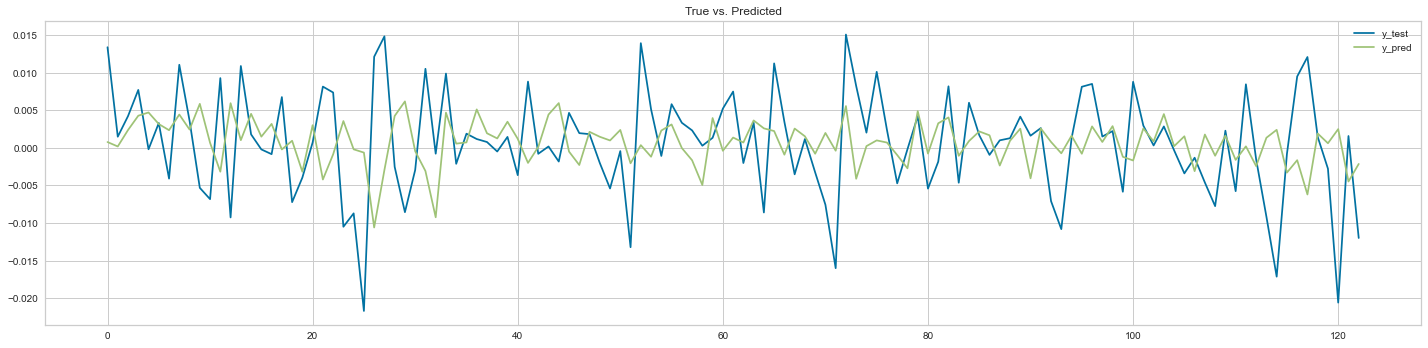

Validation Scores
root mean squared error: 0.0078721557
mean squared error: 6.19708e-05
mean absolute error: 0.0059753533
R2: -0.2619096125


In [20]:
fig_true_vs_fit = mval.get_model_performance()

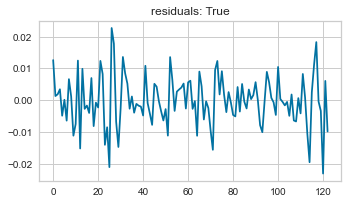

Stationarity Test Results
P-Values: 6.472973770108704e-18
Test-stats: -10.186899234233687
Time series is stationary: True
Number of lags used: 2




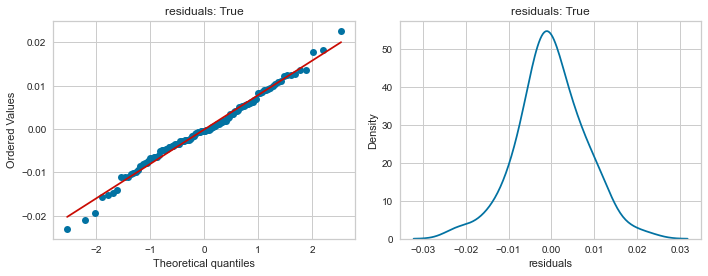

Normality Test Results
P-Values: 0.3410380090904434
Test-stats: 2.151522688603776
Series is normally distributed: True


HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


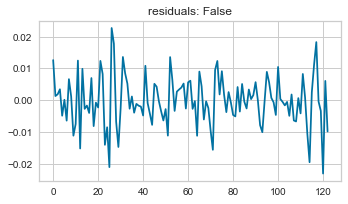

Test for Heteroskedasticity
Test p-value: 0.4575884622148497
Heteroskedasticity is present: False


TTest one sample for mean: 0
Test statistics: -0.1979167652865486
Test pvalue: 0.8434395853656309
Population mean is equal to 0: False


Durbin watson test for first oder autocorrelation
Test statistics: 1.5 < 1.912 < 2.5
First order autocorrlation is not present: : True


In [21]:
stat, norm, hetero, d_watson, zero_mean = mval.analyse_resids()

In [22]:
# update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)
data_dict["model_metrics"].update(d_watson_aucorr=d_watson)

# model performance
data_dict["model_metrics"].update(rmse=mval.rmse)
data_dict["model_metrics"].update(mse=mval.mse)
data_dict["model_metrics"].update(mae=mval.mae)
data_dict["model_metrics"].update(r2=mval.r2)
data_dict["model_metrics"].update(residuals=mval.resid_inv)

# Save model

In [23]:
save_model(model=mval.model, 
           df_train=df_train,
           data_dict=data_dict,
           plt_figures=[fig_true_vs_fit], 
           fig_titles=['fig_truefit'],
           model_dir=OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-04-01_ols_8055_years2021_2020_sp_close_lead1_sentFalse"? (y/n)


 n
